<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Prototype Target Dashboard</b> <br>
Contact author: Douglas Tucker <br>
Last verified to run: 2024-06-12 <br>
LSST Science Pipelines version: Weekly 2024_16 <br>
Container size: medium <br>

**Description:** A prototype dashboard for exploring targets (and science programs) for a given night.  This initial version focuses on AuxTel observations, but should be useful for ComCom and LSSTcam commissioning, when there will be a greater diversity of observational programs than those provided by the survey scheduler during standard operations.

See Jira issue <a href=https://rubinobs.atlassian.net/browse/PREOPS-5002>PREOPS-5002</a>.

**Credit:** Based heavily on the <a href=https://github.com/sylvielsstfr/AuxTelComm/blob/main/notebooks_usdf/ana_auxtelprod_jn/spectractor_v3.1.0_May2024/ListOfExposures-hologram-oga.ipynb> List of Exposures at USDF in OGA</a> notebook by Sylvie Dagoret-Campagne.  This initial "Prototype Target Dashboard" notebook would not have been possible without it.

## 1. Introduction

### 1.1 Import Packages

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
from IPython.display import display, HTML
import lsst.afw.display as afwDisplay
import lsst.daf.butler as dafButler

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from astropy.io import fits
from astropy.time import Time

import warnings

### 1.2. Define functions and parameters

Create a function to create a pandas DataFrame, df_grouped, that contains the results of performing a 2D groupby operation on a pandas DataFrame, df, and counts the number of entries in the col_count column for each (col_x, col_y).  One can choose to include a count of zero for cases where (col_x, col_y) have no entries in col_count (the default), or to exclude those cases.  The resulting pandas DataFrame, df_grouped, is also sorted by (col_x, col_y).

In [2]:
# Thanks to the ChatGPT on Poe.com and to https://stackoverflow.com/questions/37003100/pandas-groupby-for-zero-values for help in creating this function!

def df2Dgroupby(df, col_x, col_y, col_count, fill_zeros=True):

    if fill_zeros==True:

        df_grouped = (
            df_science.groupby([col_x, col_y])[col_count]
            .count()
            .unstack(fill_value=0)
            .stack()
            .reset_index()
            .rename(columns={0: "number"})
            .sort_values([col_x, col_y])
        )

    else:

        df_grouped = (
            df_science.groupby([col_x, col_y])[col_count]
            .count()
            .reset_index()
            .rename(columns={col_count: "number"})
            .sort_values([col_x, col_y])
        )
        
    return df_grouped

Let us also do the same, but for performing the `groupby` over 3 columns.  (Should just generalize this to `N` columns, but that can wait...) 

In [3]:
# Thanks to the ChatGPT on Poe.com and to https://stackoverflow.com/questions/37003100/pandas-groupby-for-zero-values for help in creating this function!

def df3Dgroupby(df, col_x, col_y, col_z, col_count, fill_zeros=True):

    if fill_zeros==True:

        df_grouped = (
            df_science.groupby([col_x, col_y, col_z])[col_count]
            .count()
            .unstack(fill_value=0)
            .stack()
            .reset_index()
            .rename(columns={0: "number"})
            .sort_values([col_x, col_y, col_z])
        )

    else:

        df_grouped = (
            df_science.groupby([col_x, col_y, col_z])[col_count]
            .count()
            .reset_index()
            .rename(columns={col_count: "number"})
            .sort_values([col_x, col_y, col_z])
        )
        
    return df_grouped

Create a function to plot an annotated headmap for a pandas DataFrame created by the above `df2Dgroupby` function.

In [4]:
# With a little help from https://seaborn.pydata.org/generated/seaborn.heatmap.html ...

def plotAnnotatedHeatMap_df2Dgroupby(df_grouped, col_index, col_column, col_values, title='Annotated Heatmap', cmap='Blues'):

    # Estimate a good figure size in x,y for the resulting plot...
    figsize_x = df_grouped[col_column].unique().size
    figsize_y = df_grouped[col_index].unique().size
    if figsize_y < 3:
        figsize_y = 1
    else:
        figsize_y = round(figsize_y/3)
    
    # Pivot the DataFrame to works with Seaborn heatmap...
    pivot_table = df_grouped.pivot(index=col_index, columns=col_column, values=col_values)
    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
    #fig, ax = plt.subplots(figsize=(5, 15))
    #fig, ax = plt.subplots()

    # Plot the annoated heatmap...
    sns.heatmap(pivot_table, annot=True, cmap=cmap, linecolor='Black', linewidths=0.1, ax=ax)

    # Add labels and title and rotate the x tick labels by 90 degrees...
    ax.set_xlabel(col_column)
    ax.set_ylabel(col_index)
    ax.set_title(title)
    plt.xticks(rotation=90)

Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:

In [5]:
warnings.filterwarnings("ignore")

Set default backend for afwDisplay to `matplotlib`:

In [6]:
afwDisplay.setDefaultBackend('matplotlib')

Set a few parameters to use later, when plotting:

In [7]:
plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

Define repo, collection, instrument, and day of observation to study:

<span style="color:red; font-weight:bold">I think I lost the correct repo designation that Colin told me on June 7...</span>



In [8]:
#repo = "/sdf/group/rubin/repo/main"
repo="/sdf/group/rubin/repo/oga/"
collection='LATISS/raw/all'
instrument = 'LATISS'
day_obs = 20240422

# Ops Rehearsal 3, DRP on Simulated ComCom data at USDF, Iteration #3
#  (https://confluence.lsstcorp.org/display/DM/Campaigns)
#repo='/repo/ops-rehearsal-3-prep'
#collection = 'u/homer/w_2024_12/DM-43439'
#instrument = 'LSSTComCamSim'
#day_obs = 20240404


## 2. Access data for this repo, collection, and day of observation

### 2.1 Instantiate butler and create registry

In [9]:
butler = dafButler.Butler(repo)
registry = butler.registry

Determine which dataset types exist in the collection.
(Based on material from `ops_rehearsal_comcam_analysis.ipynb`.)

In [10]:
i=0
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=collection).any(execute=False, exact=False):
        # Limit search results to the data products
        if ('_config' not in datasetType.name) and ('_log' not in datasetType.name) and ('_metadata' not in datasetType.name) and ('_resource_usage' not in datasetType.name):
            print(datasetType)
            i = i+1
print(i)

DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure)
1


What fields are available from the `exposure` dimension?

In [11]:
print(butler.registry.dimensions["exposure"].RecordClass.fields)

exposure: 
  instrument: str
  id: int
  day_obs: int
  group: str
  physical_filter: str
  obs_id: str
  exposure_time: float
  dark_time: float
  observation_type: str
  observation_reason: str
  seq_num: int
  seq_start: int
  seq_end: int
  target_name: str
  science_program: str
  tracking_ra: float
  tracking_dec: float
  sky_angle: float
  azimuth: float
  zenith_angle: float
  has_simulated: bool
  can_see_sky: bool
  timespan: lsst.daf.butler.Timespan


Good!  We have some useful info here, including the `target_name` and the `science_program`.

### 2.2 Read in information from the `exposure` dimension

Query the metadata for the `exposure` dimension, limiting the results to this particular instrument and day of observation.

In [12]:
query="instrument='%s' AND day_obs=%d" % (instrument, day_obs)
results = registry.queryDimensionRecords('exposure',where=query)
#results = registry.queryDimensionRecords('exposure',where="instrument='LATISS' AND day_obs=20240422")

How many results were returned?

In [13]:
results.count()

801

### 2.3 Create and fill a pandas `DataFrame` containing useful info from the `queryDimensionRecords` query

Instantiate a pandas `DataFrame` with useful columns available in the `exposure` dimension.

<span style="color:red; font-weight:bold">Like much else, I stole a lot of this from Sylvie's notebook.  What other useful info is accessible from the `exposure` dimension?  Answer:  probably no other useful info from the `exposure` dimension.  Need to grab other info from elsewhere.</span>


In [14]:
df_exposure = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num',
                                    'time_start','time_end' ,'type', 
                                    'target','filter','zenith_angle',
                                    'expos','ra','dec','skyangle',
                                    'azimuth','zenith','science_program',
                                    'jd','mjd'])

Read the query results into the new pandas `DataFrame`.

<span style="color:red; font-weight:bold">Iterating in python is generally slow if there are a lot of rows.  Are there any methods that quickly convert a `queryDimensionRecords` result to an AstroPy `table` or a pandas `DataFrame`?  It's not so bad for a single night, though; so maybe don't worry about it now.</span>


In [15]:
#for count, info in enumerate(registry.queryDimensionRecords('exposure',where= "instrument='LATISS'")):
for count, info in enumerate(results):
    
    
    try:
        df_exposure.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info.timespan.begin.to_string()),
                                  pd.to_datetime(info.timespan.end.to_string()),
                                  info.observation_type, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info.timespan.begin.jd,info.timespan.begin.mjd ]
    except:
        print(">>>   Unexpected error:", sys.exc_info()[0])
        info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
        info_timespan_end_to_string = "2051-01-01 00:00:00.00"
        info_timespan_begin_jd = 0
        info_timespan_begin_mjd = 0
        df_exposure.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string), 
                                  info.observation_type, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info_timespan_begin_jd, info_timespan_begin_mjd ]
 
    
    if count < 5:
        print("-----------------------------------------------------",count,"---------------------------------------------------------")
        print(info)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        
        mjd = Time(info.timespan.begin.to_string()).mjd
        jd = Time(info.timespan.begin.to_string()).jd
        print(mjd,jd)

    elif ((count%100)==0):
        print("-----------------------------------------------------",count,"---------------------------------------------------------")
 

----------------------------------------------------- 0 ---------------------------------------------------------
exposure:
  instrument: 'LATISS'
  id: 2024042200004
  day_obs: 20240422
  group: '2024-04-22T18:31:07.296'
  physical_filter: 'empty~empty'
  obs_id: 'AT_O_20240422_000004'
  exposure_time: 2.0
  dark_time: 2.23043
  observation_type: 'engtest'
  observation_reason: 'engtest'
  seq_num: 4
  seq_start: 4
  seq_end: 4
  target_name: 'AzEl'
  science_program: 'unknown'
  tracking_ra: 262.9428518614416
  tracking_dec: -38.612401069176386
  sky_angle: 119.90488527254944
  azimuth: 238.90014839888283
  zenith_angle: 19.61716388897939
  has_simulated: False
  can_see_sky: None
  timespan: Timespan(begin=astropy.time.Time('2024-04-22 18:31:08.628006', scale='tai', format='iso'), end=astropy.time.Time('2024-04-22 18:31:10.859000', scale='tai', format='iso'))
	 id:                   2024042200004
	 day_obs:              20240422
	 seq_num:              4
	 type-of-observation:  engt

Let's look at the contents of the now-filled pandas `DataFrame`.

In [16]:
df_exposure

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter,zenith_angle,expos,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd
0,2024042200004,AT_O_20240422_000004,20240422,4,2024-04-22 18:31:08.628006,2024-04-22 18:31:10.859,engtest,AzEl,empty~empty,19.617164,2.0,262.942852,-38.612401,119.904885,238.900148,19.617164,unknown,2.460423e+06,60422.771628
1,2024042200005,AT_O_20240422_000005,20240422,5,2024-04-22 19:46:37.738986,2024-04-22 19:46:39.964,engtest,DaytimeCheckout001,empty~empty,44.812258,2.0,106.592807,4.383671,172.765429,44.677726,44.812258,unknown,2.460423e+06,60422.824048
2,2024042200006,AT_O_20240422_000006,20240422,6,2024-04-22 19:49:54.895993,2024-04-22 19:49:57.137,engtest,DaytimeCheckout002,SDSSg_65mm~blue300lpmm_qn1,10.001000,2.0,77.391051,-20.273191,100.003402,358.495808,10.001000,unknown,2.460423e+06,60422.826330
3,2024042200024,AT_O_20240422_000024,20240422,24,2024-04-22 20:52:22.018014,2024-04-22 20:52:22.026,bias,FlatField position,SDSSr_65mm~empty,51.036129,0.0,56.606792,-78.779339,NaN,188.767316,51.036129,unknown,2.460423e+06,60422.869699
4,2024042200035,AT_O_20240422_000035,20240422,35,2024-04-22 20:56:44.973015,2024-04-22 20:57:14.983,dark,FlatField position,SDSSr_65mm~empty,51.036475,30.0,57.711592,-78.777418,NaN,188.767243,51.036475,unknown,2.460423e+06,60422.872743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,2024042200134,AT_O_20240422_000134,20240422,134,2024-04-22 21:28:33.111006,2024-04-22 21:28:39.123,dark,FlatField position,empty~SDSSy_65mm,51.037606,6.0,65.724903,-78.761417,NaN,188.766911,51.037606,unknown,2.460423e+06,60422.894828
797,2024042200163,AT_O_20240422_000163,20240422,163,2024-04-22 21:45:00.837010,2024-04-22 21:45:01.848,dark,FlatField position,empty~empty,51.037949,1.0,69.869934,-78.752497,NaN,188.766827,51.037949,unknown,2.460423e+06,60422.906260
798,2024042200166,AT_O_20240422_000166,20240422,166,2024-04-22 21:45:11.347997,2024-04-22 21:45:12.360,dark,FlatField position,empty~empty,51.037952,1.0,69.916068,-78.752399,NaN,188.766823,51.037952,unknown,2.460423e+06,60422.906381
799,2024042200165,AT_O_20240422_000165,20240422,165,2024-04-22 21:45:07.844013,2024-04-22 21:45:08.855,dark,FlatField position,empty~empty,51.037951,1.0,69.899279,-78.752433,NaN,188.766829,51.037951,unknown,2.460423e+06,60422.906341


Let's re-cast the `id`, `day_obs`, and `seq_num` rows as `int`'s.

In [17]:
df_exposure = df_exposure.astype({"id": int,'day_obs': int,'seq_num':int})

And look at `df_exposure` once again.

In [18]:
df_exposure

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter,zenith_angle,expos,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd
0,2024042200004,AT_O_20240422_000004,20240422,4,2024-04-22 18:31:08.628006,2024-04-22 18:31:10.859,engtest,AzEl,empty~empty,19.617164,2.0,262.942852,-38.612401,119.904885,238.900148,19.617164,unknown,2.460423e+06,60422.771628
1,2024042200005,AT_O_20240422_000005,20240422,5,2024-04-22 19:46:37.738986,2024-04-22 19:46:39.964,engtest,DaytimeCheckout001,empty~empty,44.812258,2.0,106.592807,4.383671,172.765429,44.677726,44.812258,unknown,2.460423e+06,60422.824048
2,2024042200006,AT_O_20240422_000006,20240422,6,2024-04-22 19:49:54.895993,2024-04-22 19:49:57.137,engtest,DaytimeCheckout002,SDSSg_65mm~blue300lpmm_qn1,10.001000,2.0,77.391051,-20.273191,100.003402,358.495808,10.001000,unknown,2.460423e+06,60422.826330
3,2024042200024,AT_O_20240422_000024,20240422,24,2024-04-22 20:52:22.018014,2024-04-22 20:52:22.026,bias,FlatField position,SDSSr_65mm~empty,51.036129,0.0,56.606792,-78.779339,NaN,188.767316,51.036129,unknown,2.460423e+06,60422.869699
4,2024042200035,AT_O_20240422_000035,20240422,35,2024-04-22 20:56:44.973015,2024-04-22 20:57:14.983,dark,FlatField position,SDSSr_65mm~empty,51.036475,30.0,57.711592,-78.777418,NaN,188.767243,51.036475,unknown,2.460423e+06,60422.872743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,2024042200134,AT_O_20240422_000134,20240422,134,2024-04-22 21:28:33.111006,2024-04-22 21:28:39.123,dark,FlatField position,empty~SDSSy_65mm,51.037606,6.0,65.724903,-78.761417,NaN,188.766911,51.037606,unknown,2.460423e+06,60422.894828
797,2024042200163,AT_O_20240422_000163,20240422,163,2024-04-22 21:45:00.837010,2024-04-22 21:45:01.848,dark,FlatField position,empty~empty,51.037949,1.0,69.869934,-78.752497,NaN,188.766827,51.037949,unknown,2.460423e+06,60422.906260
798,2024042200166,AT_O_20240422_000166,20240422,166,2024-04-22 21:45:11.347997,2024-04-22 21:45:12.360,dark,FlatField position,empty~empty,51.037952,1.0,69.916068,-78.752399,NaN,188.766823,51.037952,unknown,2.460423e+06,60422.906381
799,2024042200165,AT_O_20240422_000165,20240422,165,2024-04-22 21:45:07.844013,2024-04-22 21:45:08.855,dark,FlatField position,empty~empty,51.037951,1.0,69.899279,-78.752433,NaN,188.766829,51.037951,unknown,2.460423e+06,60422.906341


### 2.4 Read in the EFD for the day of observation

(Based on material from `ops_rehearsal_comcam_analysis.ipynb`)

<span style="color:red; font-weight:bold">Note much luck here for the AuxTel data I've been working with.</span>


In [19]:
from lsst_efd_client import EfdClient
client = EfdClient("usdfdev_efd", db_name="lsst.dm")

In [20]:
topics = await client.get_topics()
for t in topics: print(t)

lsst.dm.NumDiaSources
lsst.dm.NumStreakCenterDiaSources
lsst.dm.NumStreakDiaSources
lsst.dm.ap12PsfSky
lsst.dm.astromColorDiffMetrics
lsst.dm.astromDiffMetrics
lsst.dm.blendMetrics
lsst.dm.calexpMetrics
lsst.dm.calexpSummaryMetrics
lsst.dm.calibrate
lsst.dm.constantTool
lsst.dm.diaSourcesGoodVsBadRatio
lsst.dm.diffimMetadataMetric
lsst.dm.e1Diff
lsst.dm.e1DiffScatterMetric
lsst.dm.e2Diff
lsst.dm.e2DiffScatterMetric
lsst.dm.isolatedDeblenderMetrics
lsst.dm.matchedRefAngularSeparationChi
lsst.dm.matchedRefAngularSeparationDiff
lsst.dm.matchedRefCModelColorChi
lsst.dm.matchedRefCModelColorDiff
lsst.dm.matchedRefCModelFluxChiMetric
lsst.dm.matchedRefCModelMagChi
lsst.dm.matchedRefCModelMagDiff
lsst.dm.matchedRefCModelMagDiffMetric
lsst.dm.matchedRefMagChiMetric
lsst.dm.matchedRefPositionDecChi
lsst.dm.matchedRefPositionDecDiff
lsst.dm.matchedRefPositionRaChi
lsst.dm.matchedRefPositionRaDiff
lsst.dm.matchedRefPositionXChi
lsst.dm.matchedRefPositionXChiMetric
lsst.dm.matchedRefPositionXDiff


In [21]:
#query = '''SELECT * FROM "lsst.dm.e1Diff" WHERE time > now() - 100d '''
#query = '''SELECT * FROM "lsst.dm.calexpMetrics" WHERE time > now() - 100d '''
query = '''SELECT DISTINCT day_obs FROM "lsst.dm.calexpMetrics"'''
df = await client.influx_client.query(query)
df.columns.values
df

,distinct
0,


In [22]:
df.iloc[0]

distinct    
Name: 0, dtype: object

In [23]:
#refs = list(b_rehearsal.registry.queryDatasets("visitSummary", dataId={"visit": 7024040400918}))
#registry.queryDatasets("visitSummary")
#registry.queryDatasets('ccdVisitTable')

## 3. Analyse results of the query

For the rest of the notebook, we do not want to restrict the the number of rows displayed for
pandas tabular information.  Therefore, let us turn off the pandas maximum rows setting.  We will turn it back on at the end of the notebook.

In [24]:
# Change the display.max_rows option
pd.set_option("display.max_rows", None)

### 3.1 Counts

First, let's tabulate the counts of different types of exposures taken on this date.

In [25]:
df_exposure.groupby("type").count()["id"]

type
acq        101
bias        36
cwfs        54
dark        37
engtest     66
flat       175
science    332
Name: id, dtype: int64

We are primarily interested in just the science exposures.  Let's create a `DataFrame` containing just the science exposures.

In [26]:
df_science = df_exposure[df_exposure.type == 'science']

Next, let's look at the counts of exposures for the different science programs run on this date.

In [27]:
df_science.groupby("science_program").count()["id"]

science_program
AUXTEL_PHOTO_IMAGING    153
spec-survey             179
Name: id, dtype: int64

Let's plot this as a 1D histogram.

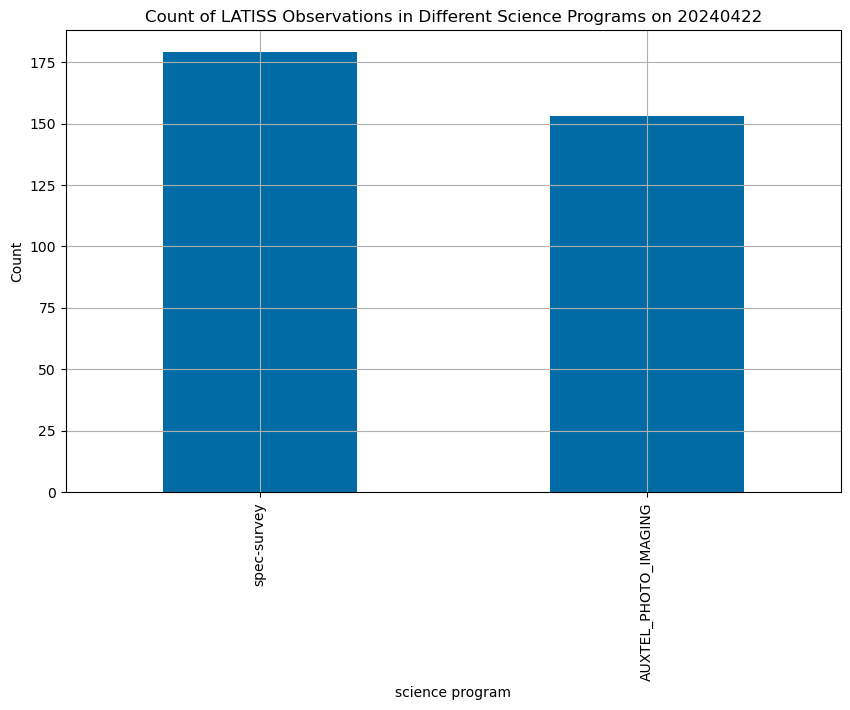

In [28]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each unique value in col1
value_counts = df_science['science_program'].value_counts()

# Create the bar plot
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('science program')
plt.ylabel('Count')
title = "Count of %s Observations in Different Science Programs on %s" % (instrument, day_obs)
plt.title(title)
plt.grid(True)


Now, let's look at the counts of exposures for the different targets observed on this date.

In [29]:
df_science.groupby("target").count()["id"]

target
HD111235           70
HD144334           74
HD185975           20
HD38666            15
Photo0800-1_001     4
Photo0800-1_002     4
Photo0800-1_003     4
Photo0800-1_004     4
Photo0800-1_005     4
Photo0800-1_006     4
Photo0800-1_007     4
Photo0800-1_008     4
Photo0800-1_009     4
Photo0800-1_010     4
Photo0800-1_011     4
Photo0800-1_012     4
Photo0800-1_013     4
Photo0800-1_014     4
Photo0800-1_015     4
Photo0800-1_016     4
Photo0800-1_017     4
Photo0800-1_018     4
Photo0800-1_019     4
Photo0800-1_020     4
Photo0800-1_021     4
Photo0800-1_022     4
Photo0800-1_023     4
Photo0800-1_024     4
Photo1600-1_018     4
Photo1600-1_019     4
Photo1600-1_020     4
Photo1600-1_021     4
Photo1600-1_022     4
Photo1600-1_023     4
Photo1600-1_024     4
Photo1600-1_025     4
Photo1600-1_026     4
Photo1600-1_027     4
Photo1600-1_028     4
Photo1600-1_029     4
Photo1600-1_030     4
Photo1600-1_031     4
Photo1600-1_032     1
Name: id, dtype: int64

Let's plot this as a 1D histogram.

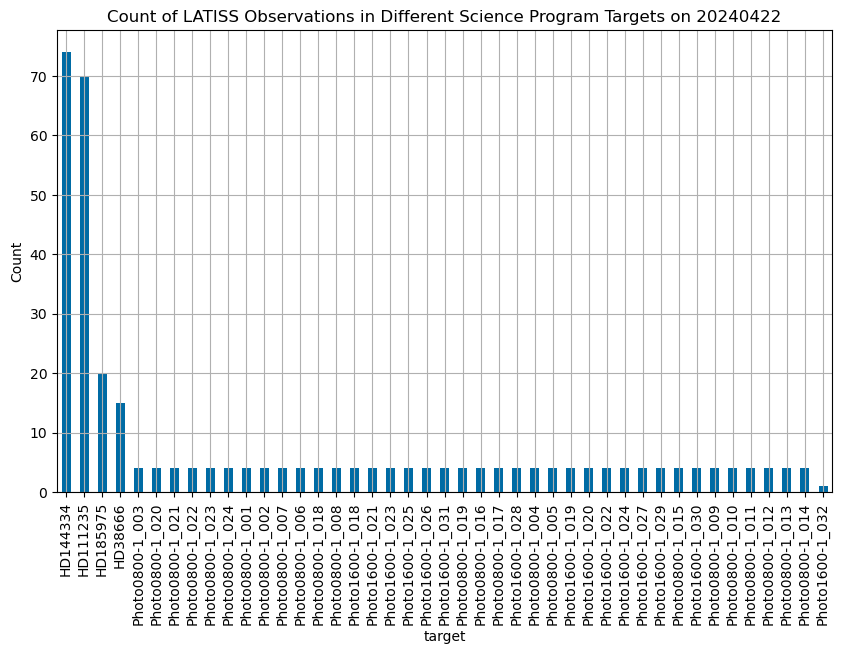

In [30]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each unique value in col1
value_counts = df_science['target'].value_counts()

# Create the bar plot
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('target')
plt.ylabel('Count')
title = """Count of %s Observations in Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


Let's organize these counts by both **science program** and **target**...

First, we will do a simple `groupby` command, using standard defaults.

In [31]:
df_science.groupby(["science_program","target"]).count()["id"]

science_program       target         
AUXTEL_PHOTO_IMAGING  Photo0800-1_001     4
                      Photo0800-1_002     4
                      Photo0800-1_003     4
                      Photo0800-1_004     4
                      Photo0800-1_005     4
                      Photo0800-1_006     4
                      Photo0800-1_007     4
                      Photo0800-1_008     4
                      Photo0800-1_009     4
                      Photo0800-1_010     4
                      Photo0800-1_011     4
                      Photo0800-1_012     4
                      Photo0800-1_013     4
                      Photo0800-1_014     4
                      Photo0800-1_015     4
                      Photo0800-1_016     4
                      Photo0800-1_017     4
                      Photo0800-1_018     4
                      Photo0800-1_019     4
                      Photo0800-1_020     4
                      Photo0800-1_021     4
                      Photo0800-1_022 

We can make this look nicer (and more useful) by converting the results into a pandas DataFrame and outputting the tabular format.  We will make use of the `df2Dgroupby` function defined in Section 1.2.  In this case, we don't care about targets that have a count of 0; so we set the `fill_zeros` parameter to `False`.

In [32]:
df_science_grouped = df2Dgroupby(df_science, 'science_program', 'target', 'id', False)
df_science_grouped

,science_program,target,number
0,AUXTEL_PHOTO_IMAGING,Photo0800-1_001,4
1,AUXTEL_PHOTO_IMAGING,Photo0800-1_002,4
2,AUXTEL_PHOTO_IMAGING,Photo0800-1_003,4
3,AUXTEL_PHOTO_IMAGING,Photo0800-1_004,4
4,AUXTEL_PHOTO_IMAGING,Photo0800-1_005,4
5,AUXTEL_PHOTO_IMAGING,Photo0800-1_006,4
6,AUXTEL_PHOTO_IMAGING,Photo0800-1_007,4
7,AUXTEL_PHOTO_IMAGING,Photo0800-1_008,4
8,AUXTEL_PHOTO_IMAGING,Photo0800-1_009,4
9,AUXTEL_PHOTO_IMAGING,Photo0800-1_010,4


Let's plot these results as an annotated heatmap:

In [ ]:
# First, we re-group df_science, setting the `fill_zeros` parameter back to `True`.  
#  This is mostly for aesthetic reasons for the plotting below (the value of '0' 
#  will be included in the annotations for those science_progam/target combos that
#  have no observations); otherwise those boxes will be left blank).
df_science_grouped = df2Dgroupby(df_science, 'science_program', 'target', 'id', True)

# Now call the plotAnnotatedHeatMap_df2Dgroupby function defined in Section 1.2 above.
plotAnnotatedHeatMap_df2Dgroupby(df_science_grouped, 'target', 'science_program', 'number', title='Annotated Heatmap', cmap='Blues')

#plt.figure(figsize=(6, 10))
#ax = sns.histplot(data=df_science, x="science_program", y="target", cbar=True)

Now let's organize these counts by **target** and **filter**...  

In [ ]:
df_science.groupby(["target","filter"]).count()["id"]

Again, we can convert the above results into a pandas DataFrame...

In [ ]:
df_science_grouped = df2Dgroupby(df_science, 'target', 'filter', 'id', False)
df_science_grouped

Here's the annotated heatmap of the same...

In [ ]:
df_science_grouped = df2Dgroupby(df_science, 'target', 'filter', 'id', True)
plotAnnotatedHeatMap_df2Dgroupby(df_science_grouped, 'target', 'filter', 'number', title='Annotated Heatmap', cmap='Blues')

#plt.figure(figsize=(20, 10))
#ax = sns.histplot(data=df_science, x="filter", y="target", cbar=True)

Next, let's organize the counts by three variables: **science program**, **target**, and **filter**...  

In [ ]:
df_science.groupby(["science_program","target","filter"]).count()["id"]

Convert this result into a pandas DataFrame using the `df3groupby` function defined in Section 1.2 above and display the resulting table:

In [ ]:
df_science_grouped = df3Dgroupby(df_science, 'science_program', 'target', 'filter', 'id', False)
df_science_grouped

### 3.2 Positions

Plot RA, DEC...

In [ ]:
plt.figure(figsize=(6, 6))

# Plot in Cartesian coordinates
#df_science.plot('ra','dec', kind='scatter')
ax = sns.scatterplot(data=df_science, x="ra", y="dec")

# Add labels and title
plt.xlabel('RA')
plt.ylabel('DEC')
title = """RA, DEC positions of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


Plot target vs. zenith_angle:

In [ ]:
plt.figure(figsize=(10, 10))

ax = sns.scatterplot(data=df_science, x="zenith_angle", y="target")

# Add labels and title
#plt.xlabel('Zenith Angle')
#plt.ylabel('Target')
title = """Zenith distances for of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


Plot target vs. MJD:

In [ ]:
plt.figure(figsize=(10, 10))

ax = sns.scatterplot(data=df_science, x="mjd", y="target")

# Add labels and title
#plt.xlabel('Zenith Angle')
#plt.ylabel('Target')
title = """MJDs of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


## 4. Final cleanup

Reset the pandas maximum rows option it its original default.

In [ ]:
# Reset the display.max_rows option to the original default
pd.reset_option("display.max_rows")

## Sandbox